In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model 
%matplotlib inline
pd.options.mode.chained_assignment = None

In [120]:
my_data = pd.read_csv('./orders_20190822.csv', sep=";", decimal=',')


In [121]:
my_data["o_date"]=pd.to_datetime(my_data["o_date"], format='%d.%m.%Y')
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002804 entries, 0 to 2002803
Data columns (total 4 columns):
id_o       int64
user_id    int64
price      float64
o_date     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 61.1 MB


In [122]:
len(my_data.id_o.unique())== len(my_data.id_o)

True

In [123]:
my_data_filtered=my_data[(my_data.price>150) & (my_data.price<=100000)]
my_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1970296 entries, 0 to 2002803
Data columns (total 4 columns):
id_o       int64
user_id    int64
price      float64
o_date     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 75.2 MB


In [124]:
my_data_filtered["year"]=pd.DatetimeIndex(my_data_filtered["o_date"]).year
my_data_filtered["month"]=pd.DatetimeIndex(my_data_filtered["o_date"]).month
my_data_filtered.head()

,id_o,user_id,price,o_date,year,month
0,1234491,337544,539.0,2016-01-01,2016,1
1,1234494,171642,153.3,2016-01-01,2016,1
3,1234498,1105609,752.5,2016-01-01,2016,1
4,1234500,982696,4410.0,2016-01-01,2016,1
5,1234503,1105614,595.0,2016-01-01,2016,1


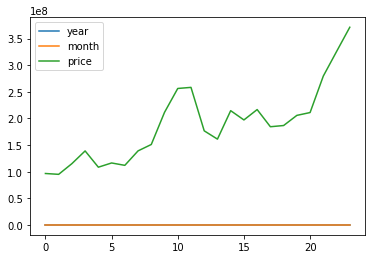

In [237]:
price_by_months=my_data_filtered.loc[:, ["price", "year", "month"]].groupby(["year","month"]).sum()
price_by_months["price"]=price_by_months["price"].round()
price_by_months=pd.DataFrame(price_by_months.to_records())
price_by_months.plot()

In [150]:
price_by_months["index"]=range(1, len(price_by_months)+1)

In [152]:
regr = linear_model.LinearRegression()
x=np.array(price_by_months["index"]).reshape(len(price_by_months), 1)
y=np.array(price_by_months["price"]).reshape(len(price_by_months), 1)
regr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

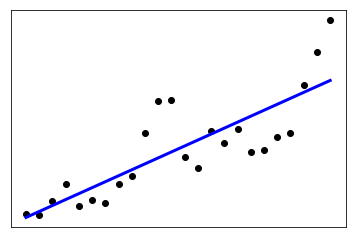

In [153]:
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [164]:
price_by_months["trend"]=regr.predict(x)
price_by_months["deviation"]=price_by_months["price"]/price_by_months["trend"]

month_deviation=price_by_months.loc[:, ["month", "deviation"]].groupby("month").mean()
common_deviation = month_deviation.mean()
common_deviation

deviation    1.00168
dtype: float64

In [186]:
seazon_coeff = month_deviation/common_deviation
seazon_coeff.head()


,deviation
month,
1,0.981557
2,0.871994
3,1.038758
4,1.043108
5,0.908183


In [182]:
trend_nexsts=regr.predict(np.array(range(25, 37)).reshape(12, 1))
trend_nexsts=trend_nexsts.reshape(1, 12)[0]

In [183]:
predict=pd.DataFrame({"month":range(1, 13), "trend":trend_nexsts})

In [220]:
for ind in predict.index.values:
    predict["price"][ind]=(predict["trend"][ind] * seazon_coeff["deviation"][predict["month"][ind]])
predict["price"]=predict["price"].astype('int32')

In [223]:
predict["real_price"]=[ 256798898,
 232640416,
 267994924,
 262849522,
 276933049,
 251486085,
 250559778,
 261724749,
 276675505,
 287647539,
 363102609,
 422386052]

In [248]:
predict["price"]

0     288420639
1     263562734
2     322706935
3     332834242
4     297422997
5     277143260
6     266840682
7     306149589
8     317199478
9     424605656
10    496307011
11    520870406
Name: price, dtype: int32

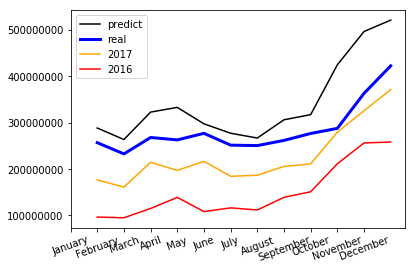

In [249]:
import calendar
plt.plot(predict['month'], predict['price'],  color='black', label="predict")
plt.plot(predict['month'], predict['real_price'], color='blue', linewidth=3, label="real")
plt.plot(predict['month'], price_by_months.loc[price_by_months.year==2017, "price"], color='orange', label="2017")
plt.plot(predict['month'], price_by_months.loc[price_by_months.year==2016, "price"], color='red', label="2016")

plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)
plt.ticklabel_format(axis='y',style='plain',scilimits=(0,3))
plt.legend()
plt.show()